In [46]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import IP2Location
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as ticker

### Датасет проекта Город с 9.10.21 по 23.10.21

In [47]:
df = pd.read_csv('gorod_09102021_231021.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df['TIME'] = pd.to_datetime(df['TIME'])
df.sort_values(by='DATE', inplace=True)


### Функции расчёта эмперических оценок

In [48]:
def unique_hits_per_day(df: DataFrame) -> float:
    """Middle percent increase unique visits (-sup,+sup)

    Args:
        df (DataFrame): logs

    Returns:
        float: grade
    """
    df = df.copy()
    df = df[df['RES'] == 200]
    df = df[~df['BROWSER'].str.contains('bot')]
    df_groupby_date = df.groupby('DATE').agg({"IP": lambda x: x.nunique()})
    df_groupby_date.reset_index(inplace=True)

    df_groupby_date['fake'] = df_groupby_date['IP'].diff(
        periods=-1).dropna()
    numerator = df_groupby_date['fake'].sum()

    denominator = df_groupby_date['IP'].sum()

    result_mark = (numerator / denominator)

    return result_mark


def regional_interest(df: DataFrame) -> float:
    """Mark region interest interest [0;+sup]

    Args:
        df (DataFrame): logs

    Returns:
        float: grade
    """
    df = df.copy()
    df = df[df['RES'] == 200]
    df = df[~df['BROWSER'].str.contains('bot')]
    ip2loc_obj = IP2Location.IP2Location(
        "logs_analyzer/data/IP2LOCATION-LITE-DB11.BIN")
    group_by_area = df.loc[:, ['IP', 'TIME']]
    group_by_area['COUNTRY'] = [ip2loc_obj.get_country_short(i)
                                for i in group_by_area['IP']]
    filter_ru = group_by_area['COUNTRY'] == 'RU'
    group_by_area = group_by_area.loc[filter_ru]
    group_by_area['REGION'] = [ip2loc_obj.get_region(i)
                               for i in group_by_area['IP']]
    res_group_by_area = group_by_area.groupby(
        'REGION')['IP'].agg(Count='count').reset_index()

    std = res_group_by_area['Count'].std()
    mean = res_group_by_area['Count'].mean()
    grade = mean/std

    return grade


def time_interests(df: DataFrame) -> float:
    """Time intereset

    Args:
        df (DataFrame): logs

    Returns:
        float: grade
    """
    df = df.copy()
    df = df[df['RES'] == 200]
    df = df[~df['BROWSER'].str.contains('bot')]
    group_by_hour = df.loc[:, ['TIME']]
    group_by_hour['TIME'] = df['TIME'].dt.hour
    uniqh = group_by_hour.groupby(['TIME'])['TIME'].agg(
        Count='count').reset_index()

    std = uniqh['Count'].std()
    mean = uniqh['Count'].mean()
    grade = mean/std

    return grade


def unique_hits_per_day_crawlers(df: DataFrame) -> float:
    """Unique hits per day crawlers grade

    Args:
        df (DataFrame): logs

    Returns:
        float: grade
    """
    df = df.copy()
    df = df[df['RES'] == 200]
    only_crawlers = df[df['BROWSER'].str.contains('bot')]
    df_groupby_date = only_crawlers.groupby('DATE').agg(
        {"IP": lambda x: x.nunique()})
    df_groupby_date.reset_index(inplace=True)

    df_groupby_date['fake'] = df_groupby_date['IP'].diff(
        periods=-1).dropna()
    numerator = df_groupby_date['fake'].sum()

    denominator = df_groupby_date['IP'].sum()

    result_mark = (numerator / denominator)

    return result_mark


def bad_requests(df: DataFrame) -> float:
    """Bad requests grade

    Args:
        good_requests (DataFrame): logs
        bad_requests (List[str]): bad logs

    Returns:
        float: grade
    """
    num_all_requests = len(df)
    num_bad_requests = len(df[df['RES'] != 200])

    grade = num_bad_requests/num_all_requests
    return 1/grade


In [49]:
dates = df['DATE'].unique()
dates

array(['2021-10-09T00:00:00.000000000', '2021-10-10T00:00:00.000000000',
       '2021-10-11T00:00:00.000000000', '2021-10-12T00:00:00.000000000',
       '2021-10-13T00:00:00.000000000', '2021-10-14T00:00:00.000000000',
       '2021-10-15T00:00:00.000000000', '2021-10-16T00:00:00.000000000',
       '2021-10-17T00:00:00.000000000', '2021-10-18T00:00:00.000000000',
       '2021-10-19T00:00:00.000000000', '2021-10-20T00:00:00.000000000',
       '2021-10-21T00:00:00.000000000', '2021-10-22T00:00:00.000000000',
       '2021-10-23T00:00:00.000000000'], dtype='datetime64[ns]')

In [50]:
results = []

for i in range(len(dates)-1):
    condition = (df['DATE'] == dates[i]) | (df['DATE'] == dates[i+1])
    sub_df = df[condition]
    x1 = unique_hits_per_day(sub_df)
    x2 = unique_hits_per_day_crawlers(sub_df)
    x3 = regional_interest(sub_df)
    x4 = time_interests(sub_df)
    x5 = bad_requests(sub_df)
    sub_list = [dates[i+1], x1, x2, x3, x4, x5]
    results.append(sub_list)
prepare_data = DataFrame(results)


In [51]:
prepare_data.columns = ['date','unique_by_day','unique_by_day_bots','regional_interests','time_interests','bad_requests']
prepare_data

,date,unique_by_day,unique_by_day_bots,regional_interests,time_interests,bad_requests
0,2021-10-10,-0.123644,0.230769,0.431888,1.310071,1.948202
1,2021-10-11,-0.061594,-0.310345,0.268240,1.631766,2.018707
2,2021-10-12,-0.036184,-0.136364,0.285747,1.363751,2.109888
3,2021-10-13,0.022727,0.282051,0.351079,1.283245,2.074301
4,2021-10-14,-0.013115,-0.243243,0.395835,1.655756,1.975627
5,2021-10-15,0.011457,0.179487,0.537444,0.887069,1.945597
6,2021-10-16,0.080501,0.000000,0.542788,0.809863,1.744015
7,2021-10-17,-0.005803,0.103448,0.593679,1.742198,1.641094
8,2021-10-18,-0.218045,-0.133333,0.650952,1.687869,1.917224
9,2021-10-19,0.004963,-0.150000,0.606514,1.824921,1.976372


### График зависимости числа Средний процент прироста числа уникальных посещений уникальных посещений от дня

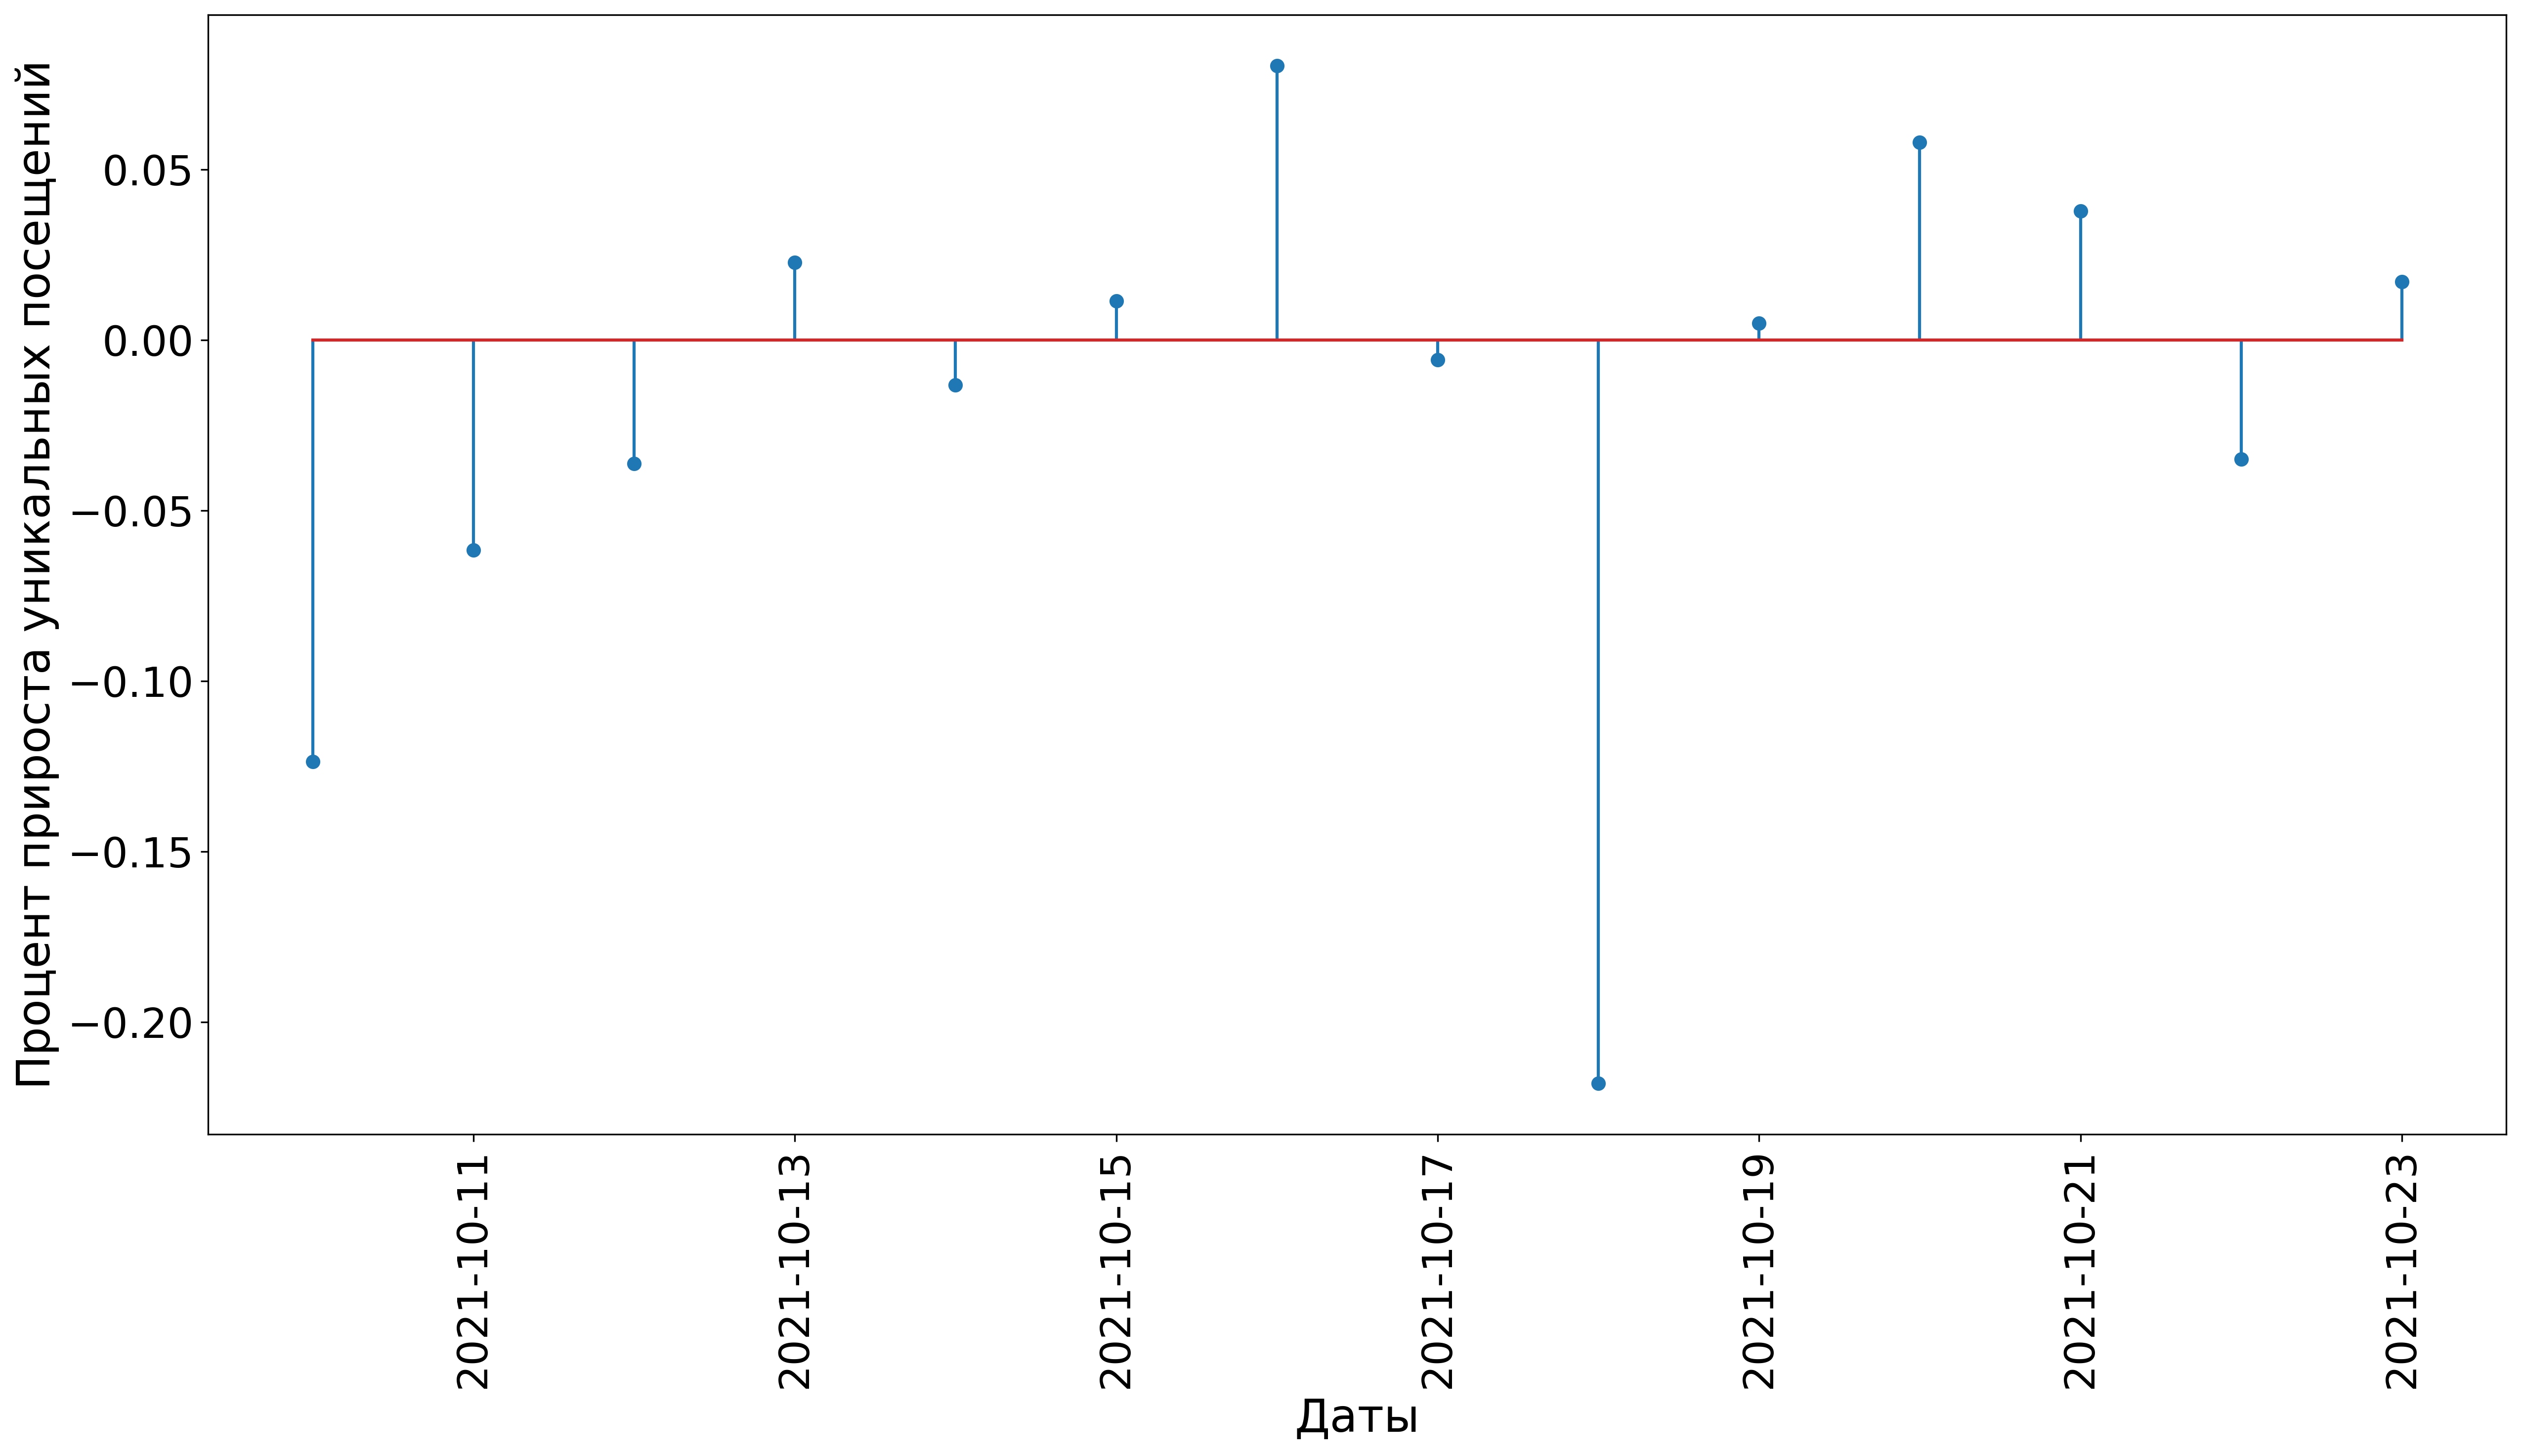

In [52]:
figure(figsize=(20,10),dpi=300)
plt.stem(prepare_data['date'], prepare_data['unique_by_day'])
plt.xlabel("Даты",fontsize=22)
plt.ylabel("Процент прироста уникальных посещений",fontsize=22)
plt.xticks(fontsize=20,rotation=90)
plt.yticks(fontsize=20)
plt.show()

### График зависимости cреднего процент прироста числа уникальных посещений  от дня поисковыми ботами

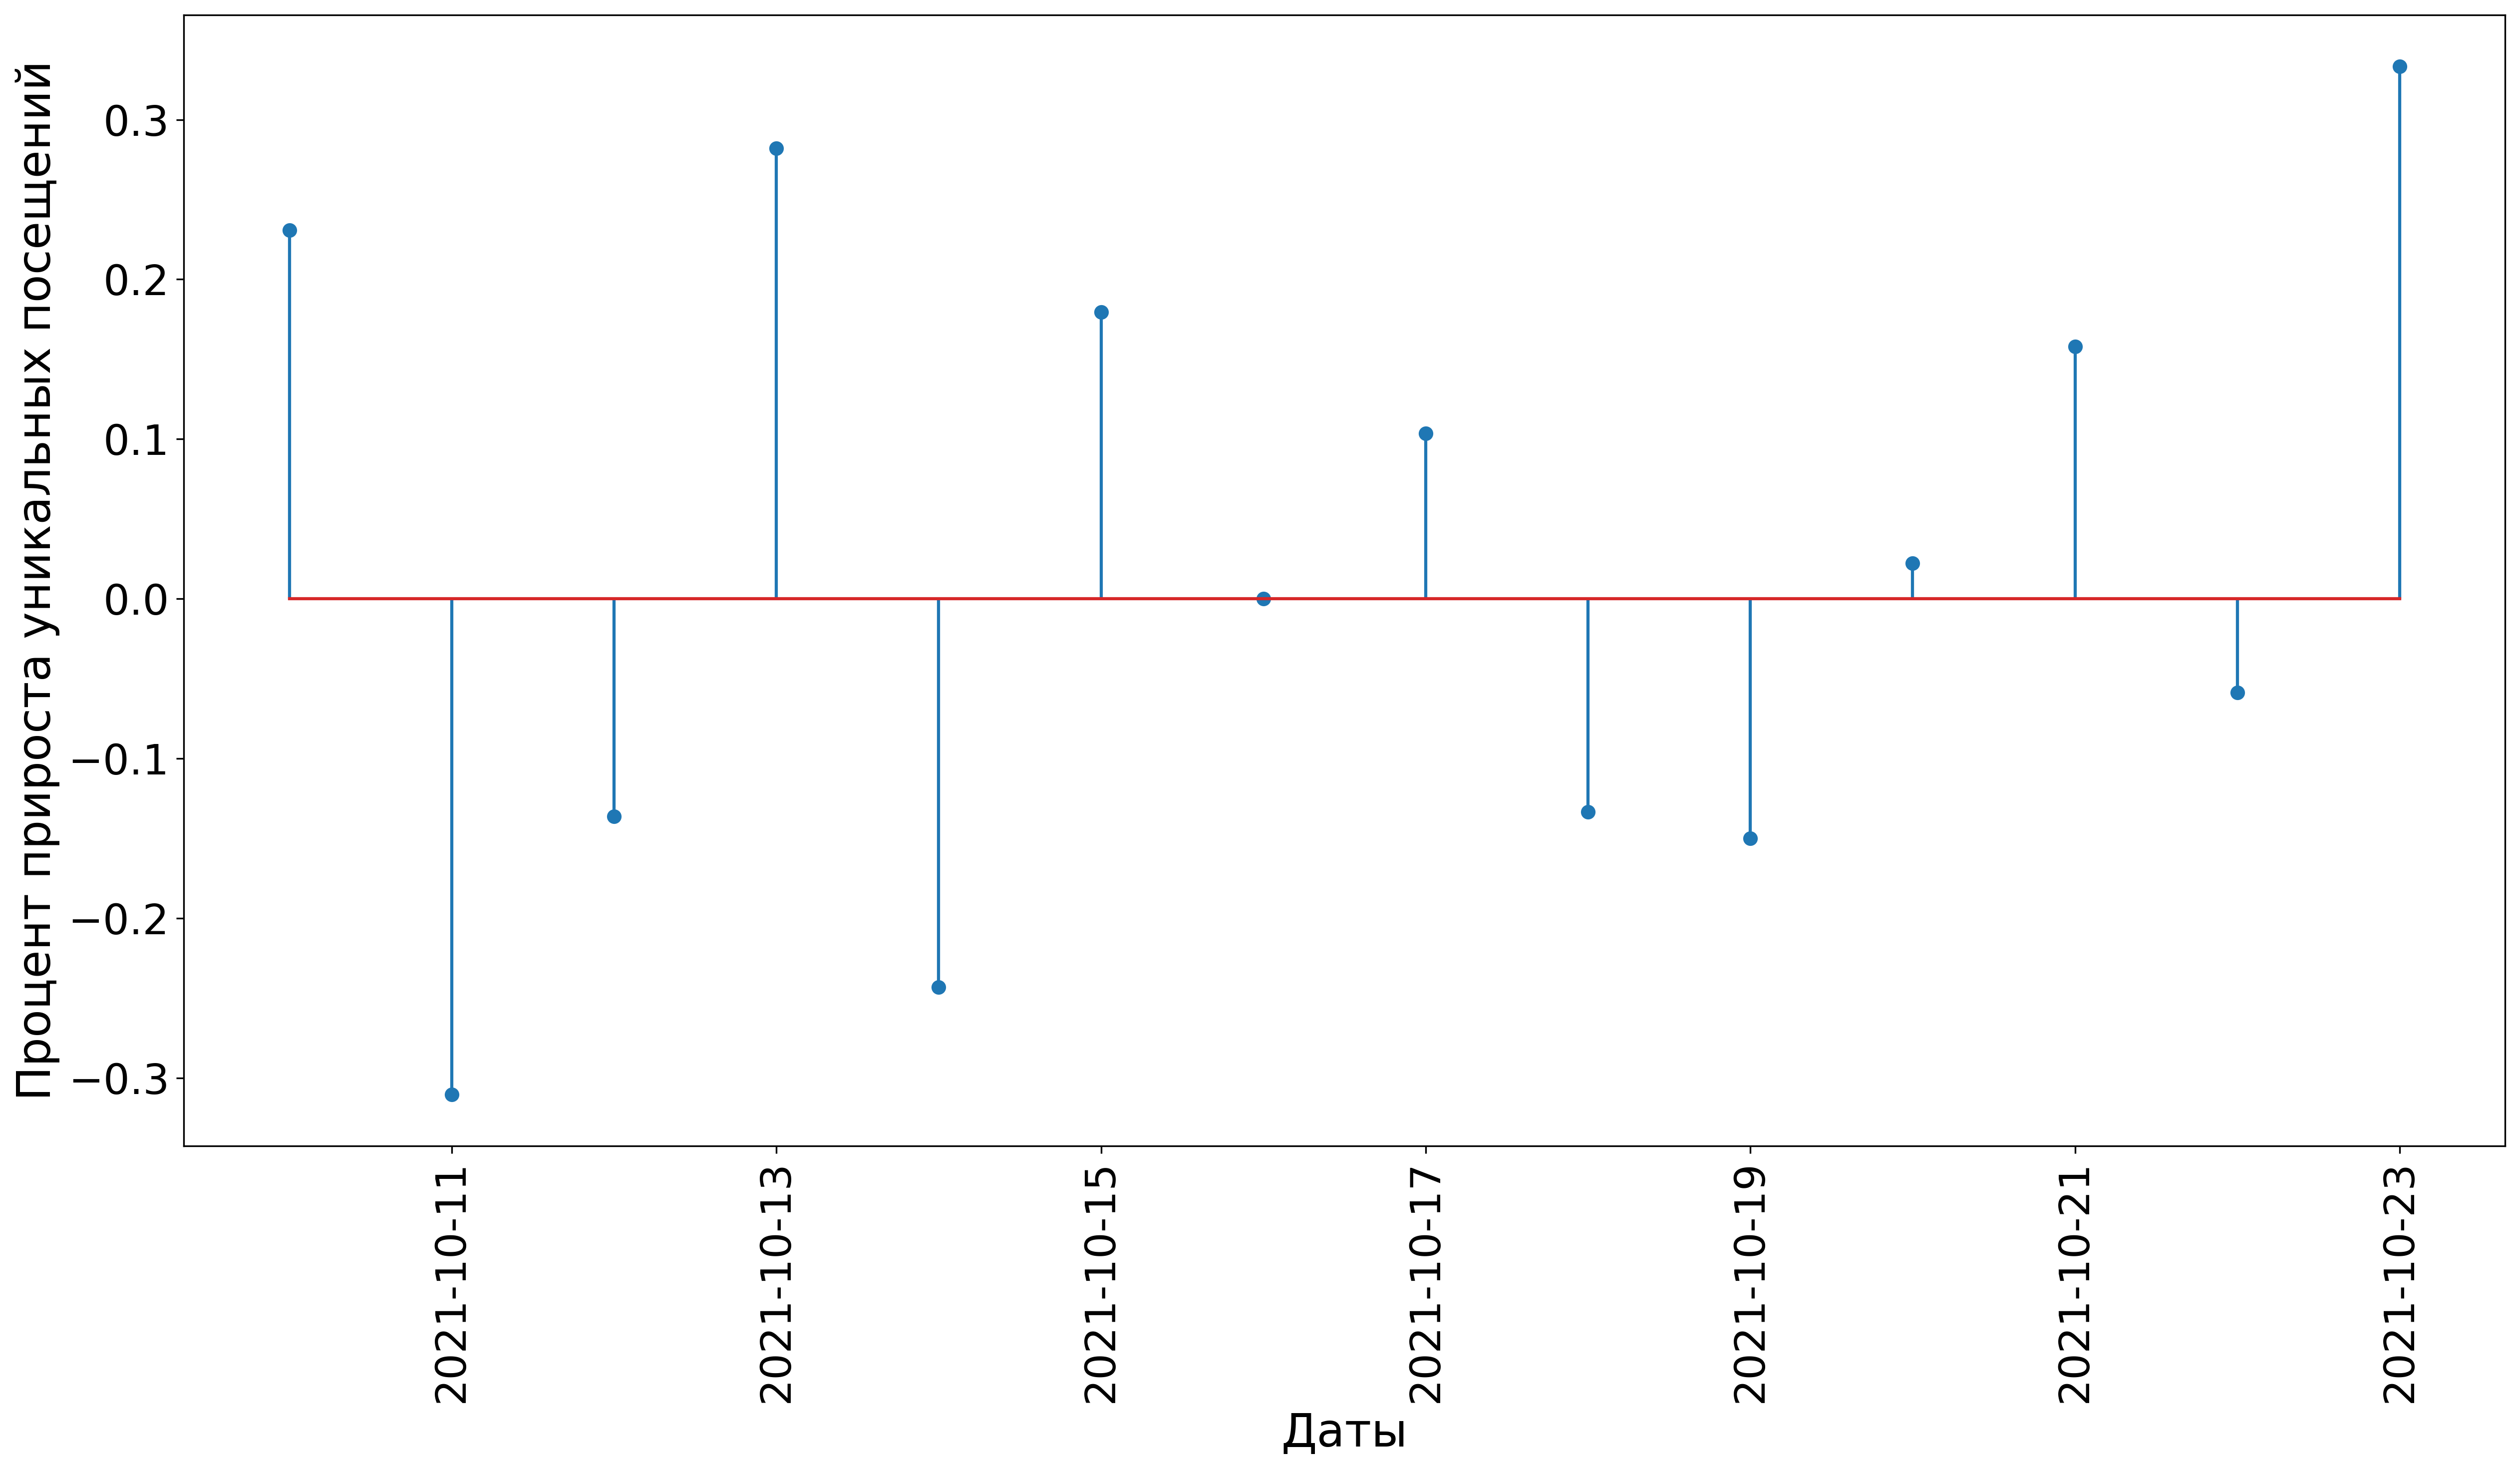

In [54]:
figure(figsize=(20,10),dpi=300)
plt.stem(prepare_data['date'], prepare_data['unique_by_day_bots'])
plt.xlabel("Даты",fontsize=22)
plt.ylabel("Процент прироста уникальных посещений",fontsize=22)
plt.xticks(fontsize=20,rotation=90)
plt.yticks(fontsize=20)
plt.show()

### График зависимости региональной заинтересованности (вариационного коэффициента) от дня

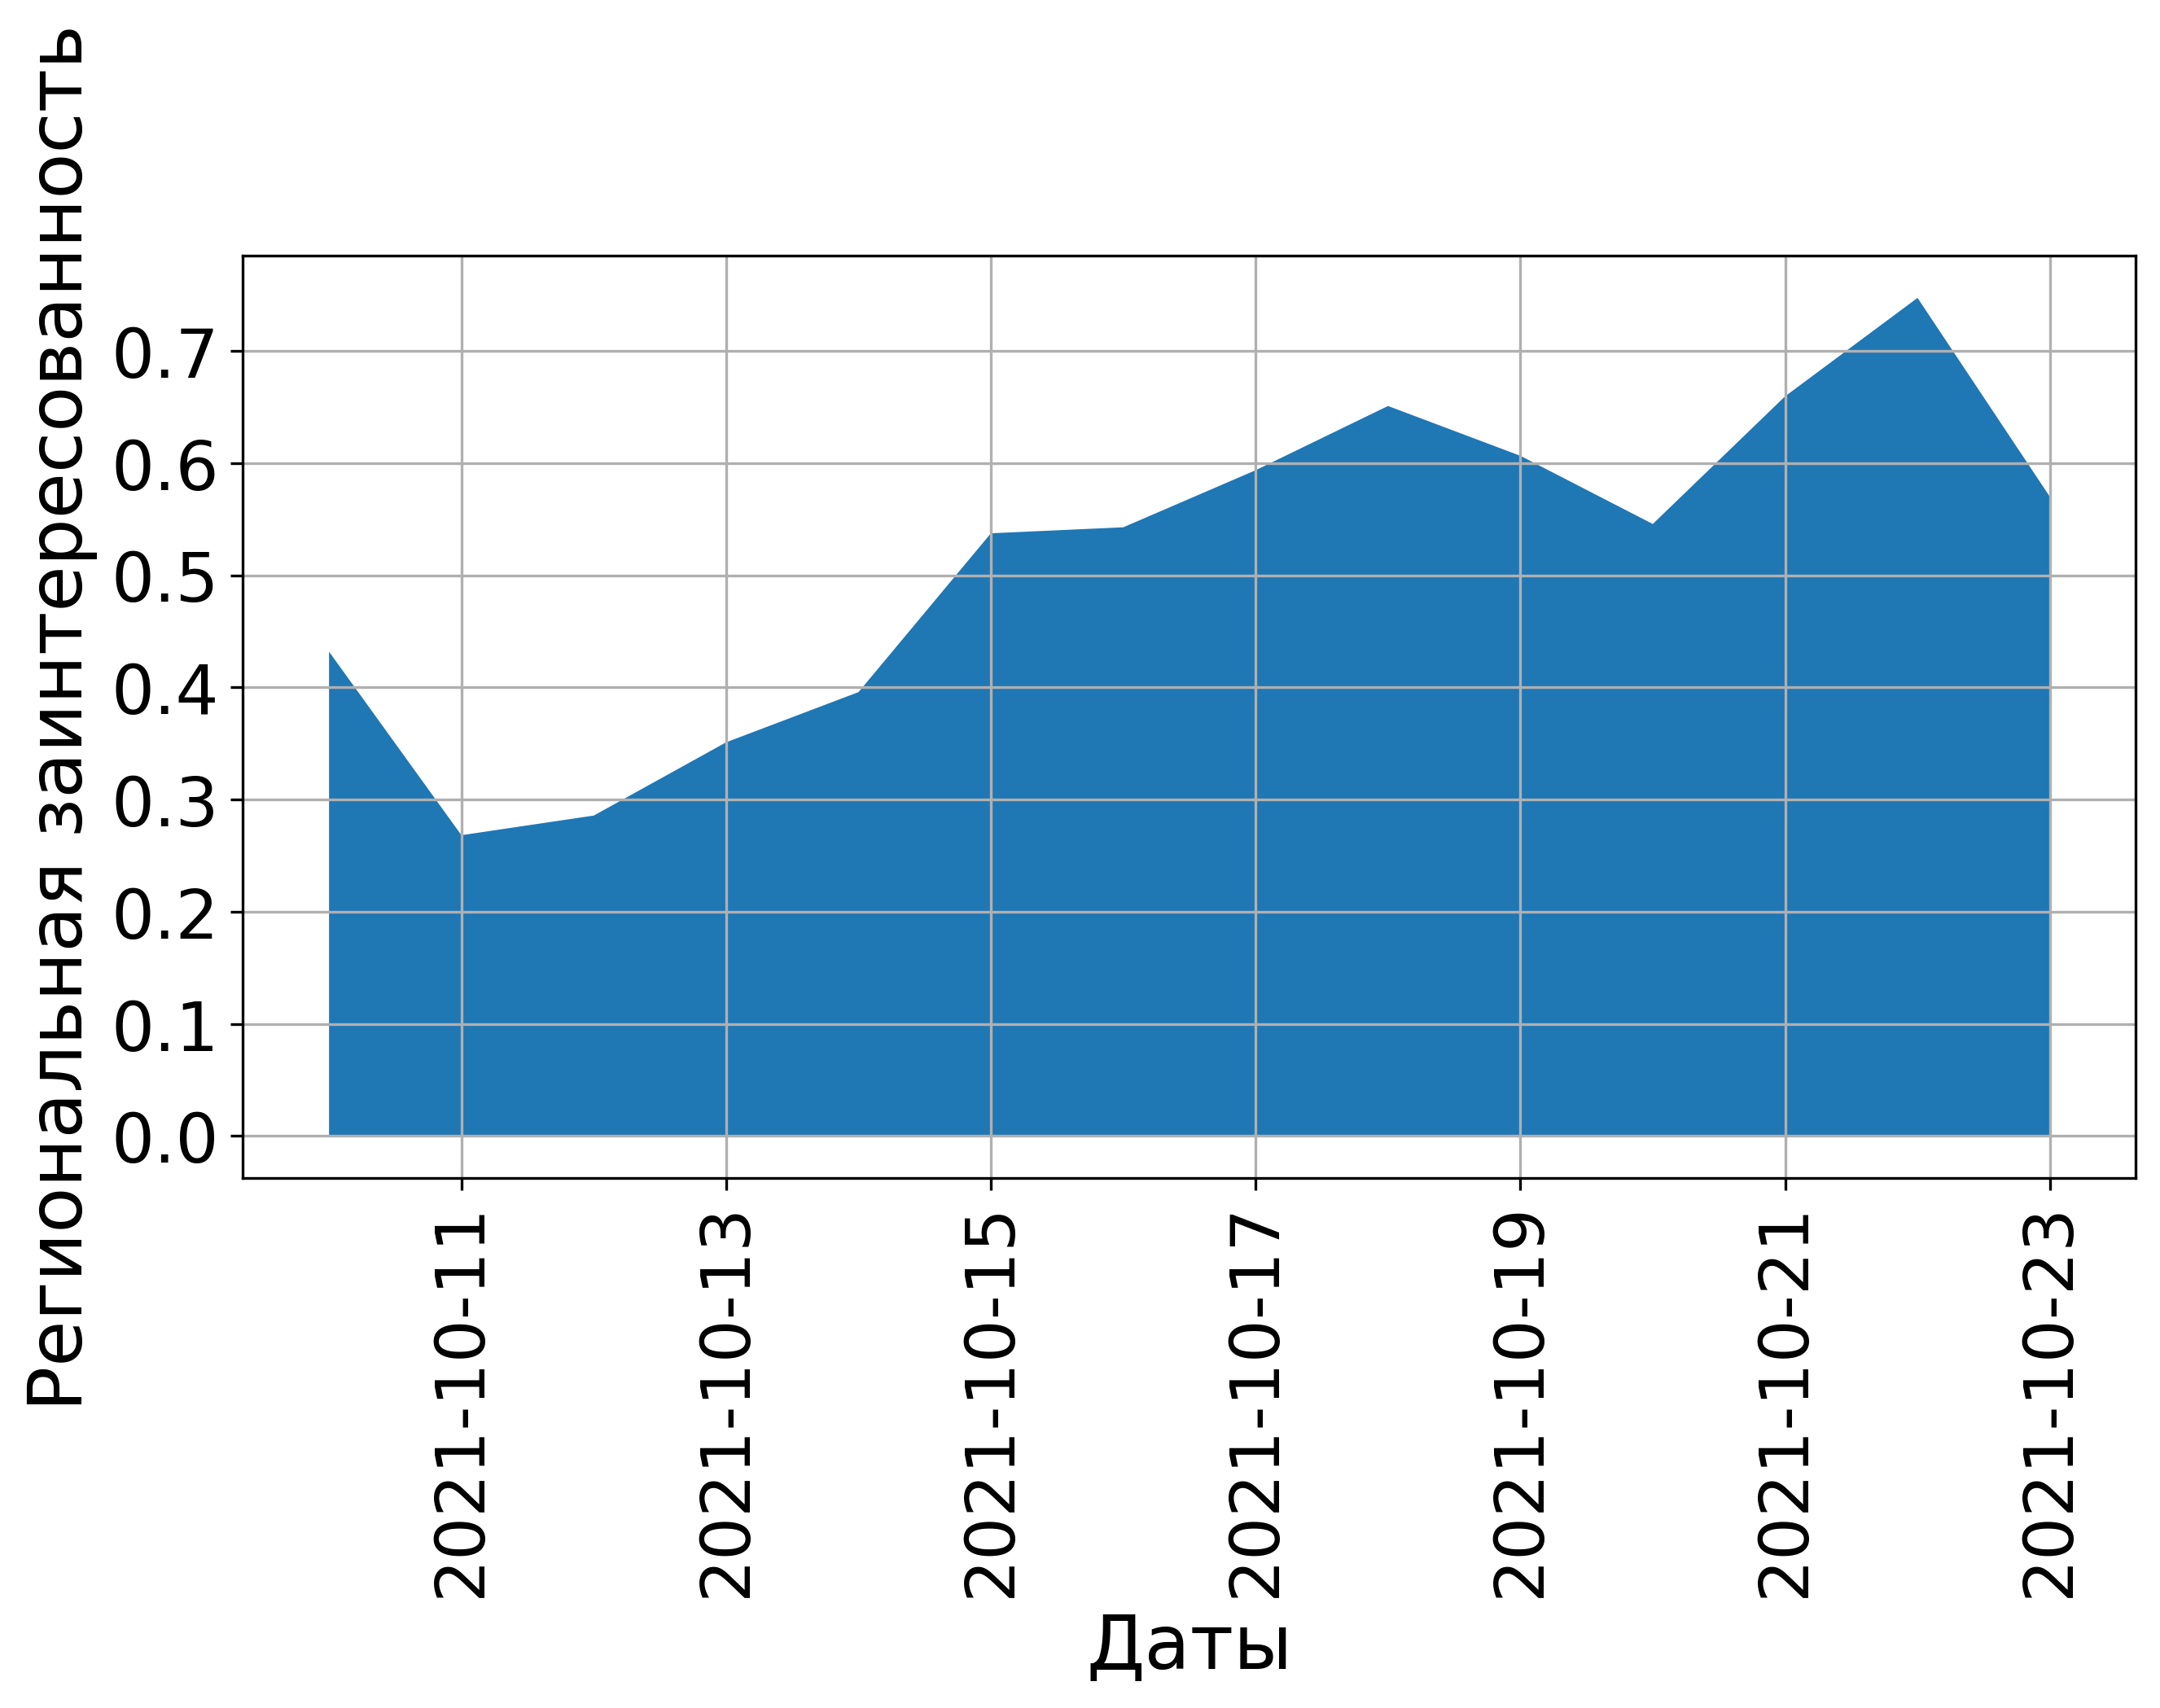

In [55]:
figure(figsize=(10,5),dpi=300)
plt.fill_between(prepare_data['date'], prepare_data['regional_interests'])
plt.xlabel("Даты",fontsize=22)
plt.ylabel("Региональная заинтересованность",fontsize=22)
plt.xticks(fontsize=20,rotation=90)
plt.yticks(fontsize=20)
plt.grid()
plt.show()

### График зависимости временной заинтересованности (вариационного коэффициента)  от дня

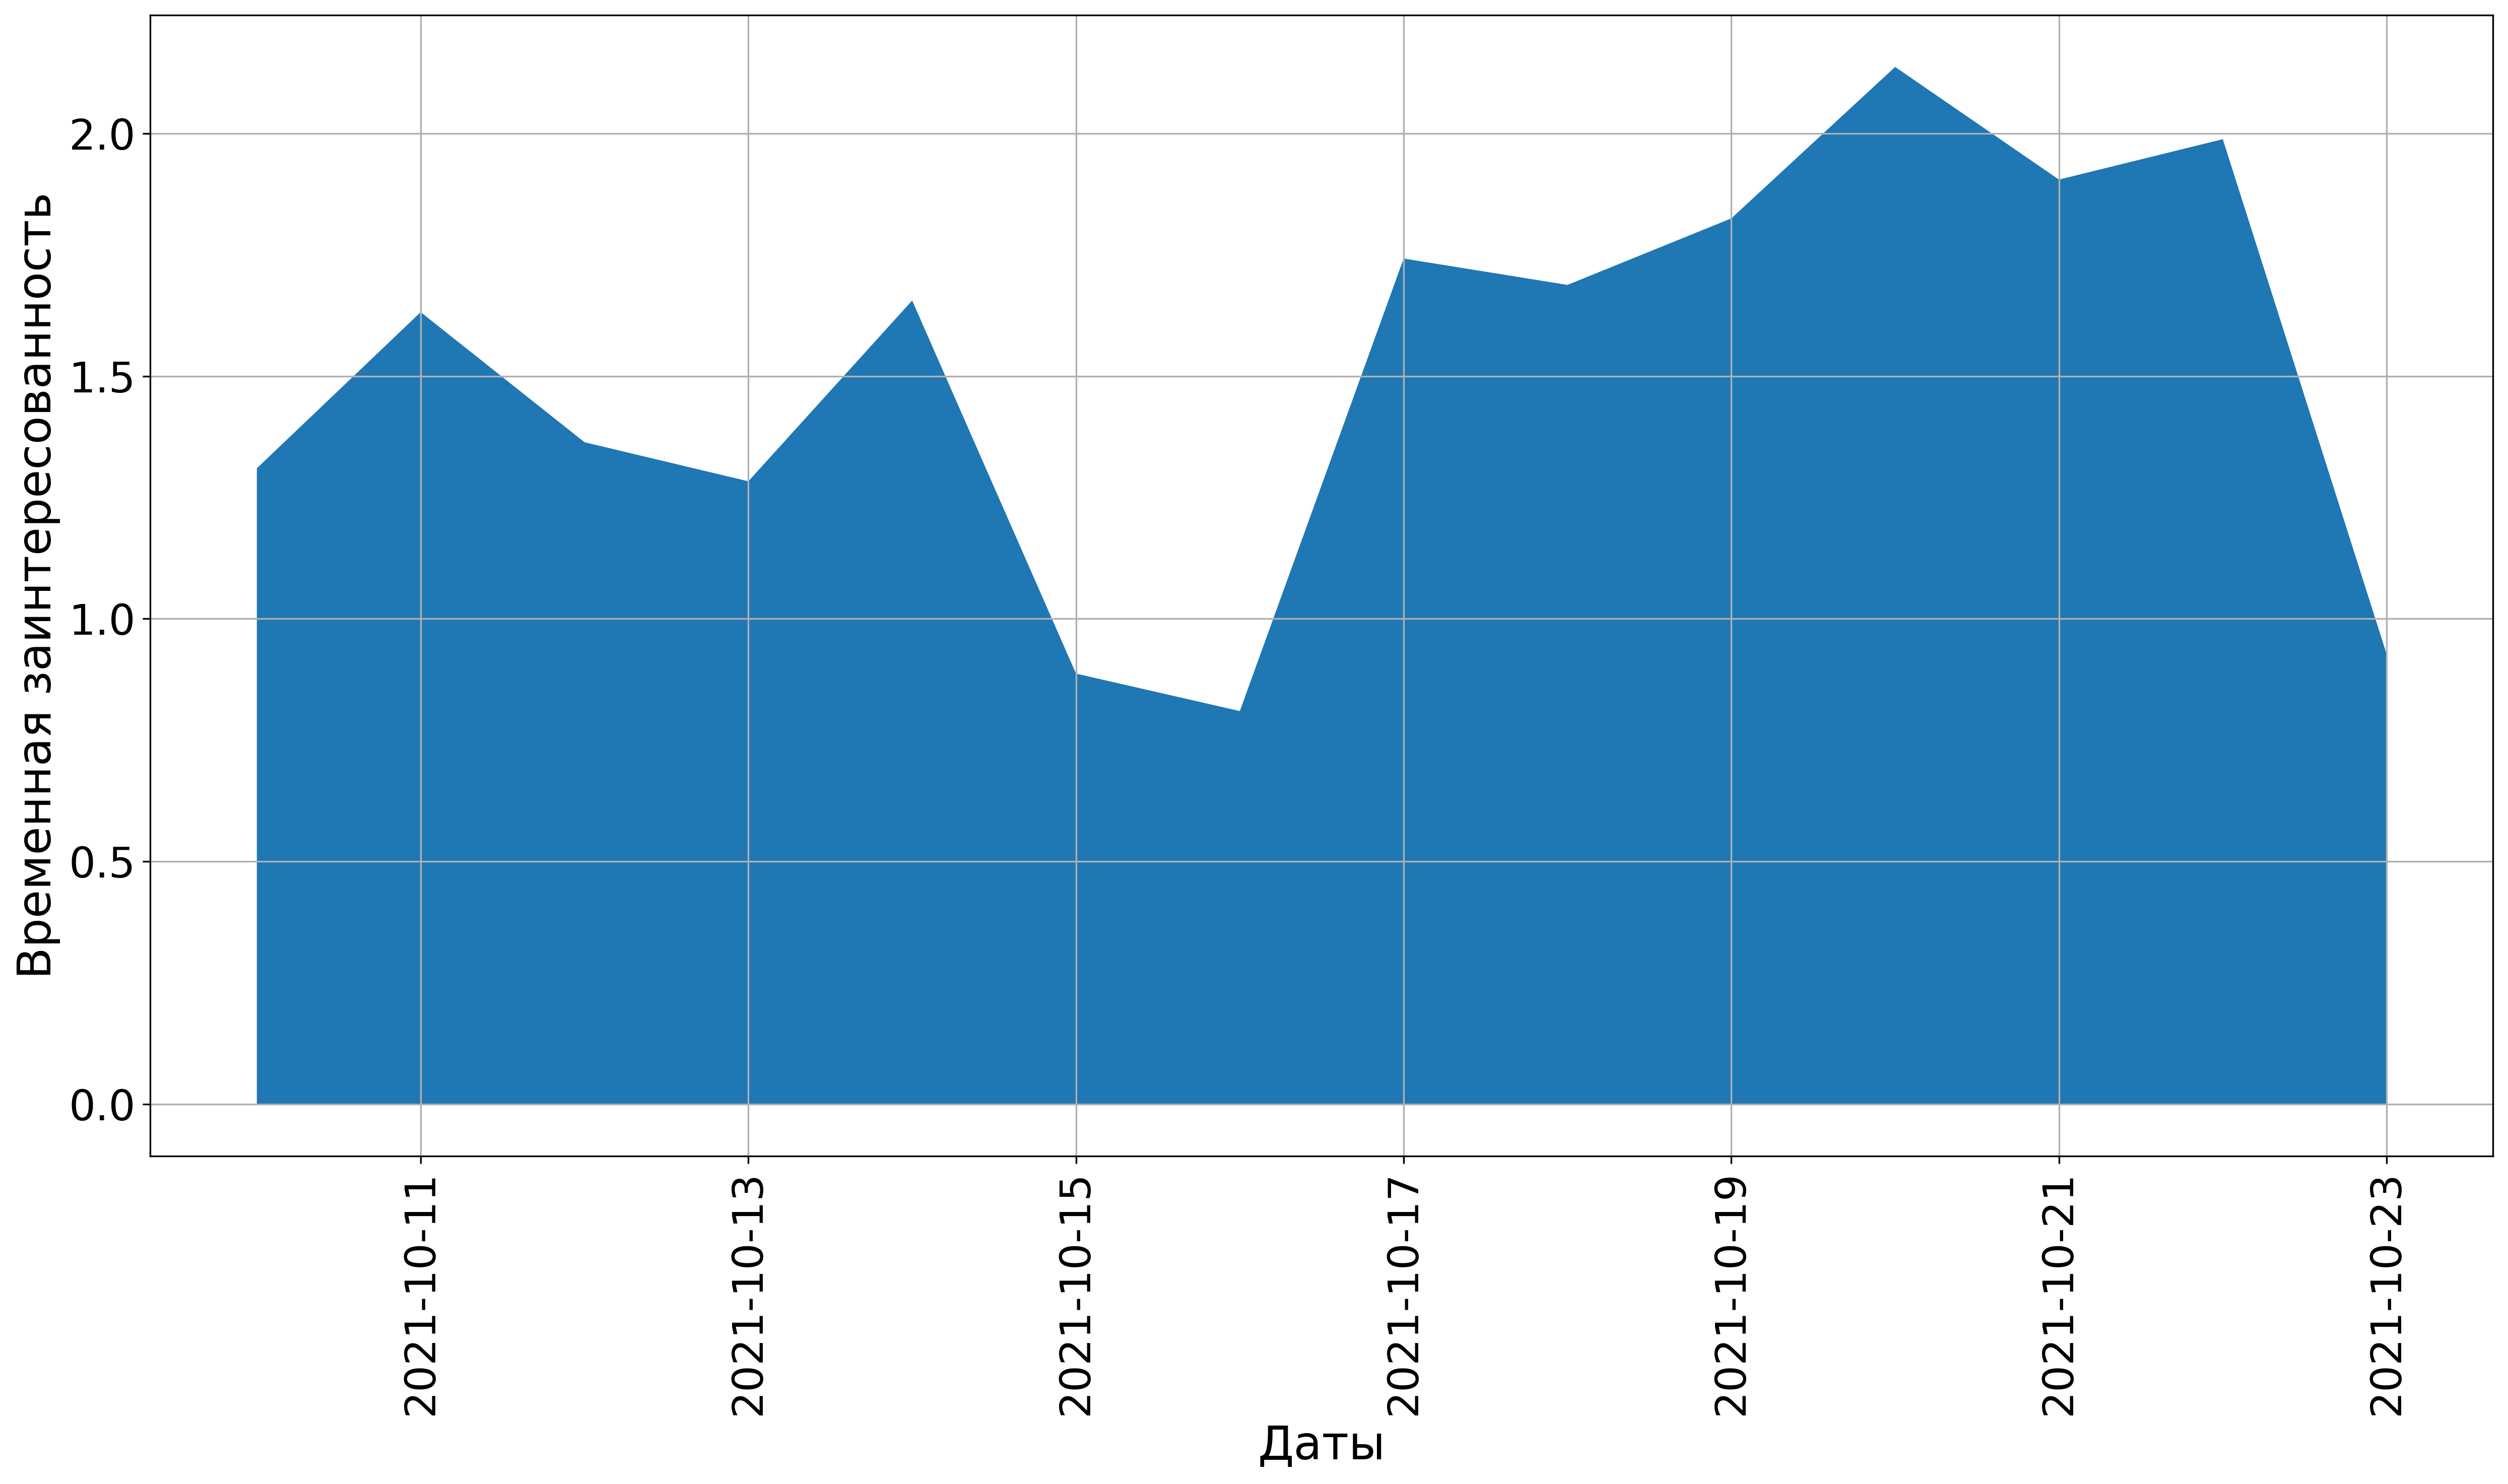

In [56]:
figure(figsize=(20,10),dpi=300)
plt.fill_between(prepare_data['date'], prepare_data['time_interests'])
plt.xlabel("Даты",fontsize=22)
plt.ylabel("Временная заинтересованность",fontsize=22)
plt.xticks(fontsize=20,rotation=90)
plt.yticks(fontsize=20)
plt.grid()
plt.show()

### График зависимости процента ошибочных запросов от дня

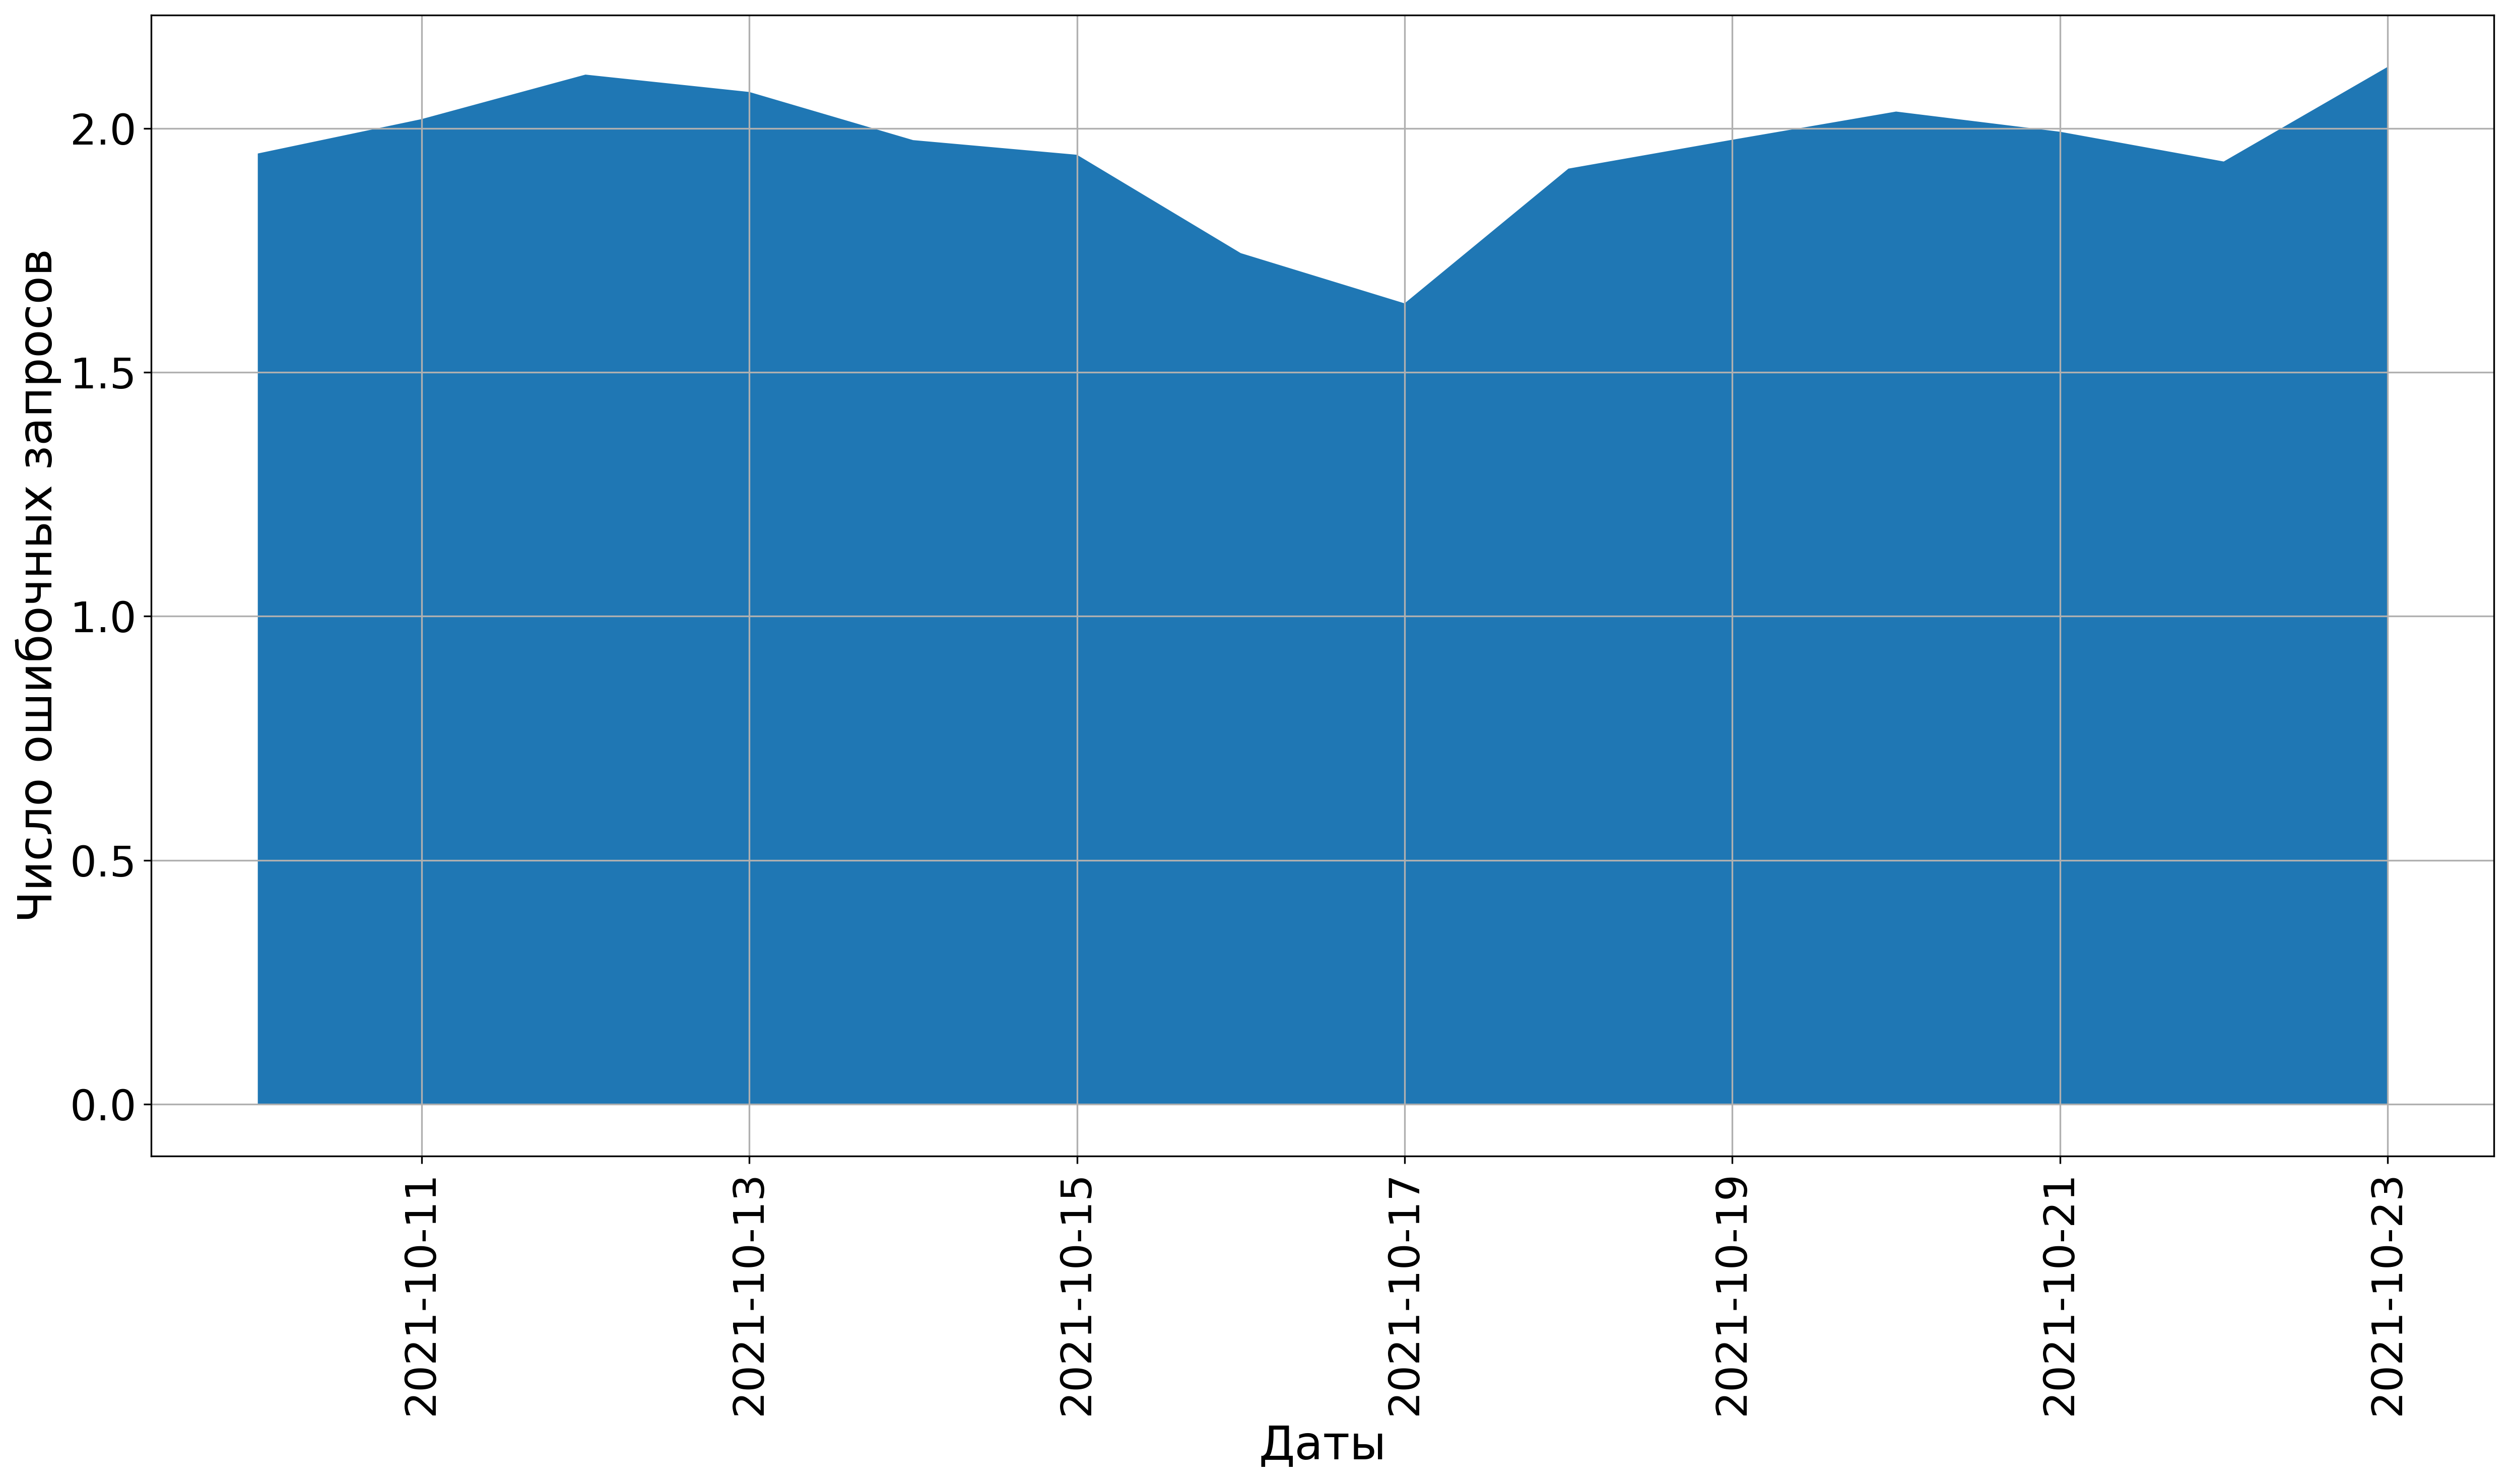

In [57]:
figure(figsize=(20,10),dpi=300)
plt.fill_between(prepare_data['date'], prepare_data['bad_requests'])
plt.xlabel("Даты",fontsize=22)
plt.ylabel("Число ошибочных запросов",fontsize=22)
plt.xticks(fontsize=20,rotation=90)
plt.yticks(fontsize=20)
plt.grid()
plt.show()

### Подсчёт имеджевой оценки

Весовые коэф-ты

In [58]:
w1 = w2 = w3 = w4 = w5 = 1
prepare_data.columns = ['date','x1','x2','x3','x4','x5']
df = prepare_data

In [59]:
df['grade'] = np.sqrt(w1*(df['x1']**2)+w2*(df['x2']**2)+w3 *
                      (df['x3']**2)+w4*(df['x4']**2)+w5*(df['x5']**2))
df


,date,x1,x2,x3,x4,x5,grade
0,2021-10-10,-0.123644,0.230769,0.431888,1.310071,1.948202,2.401426
1,2021-10-11,-0.061594,-0.310345,0.268240,1.631766,2.018707,2.628669
2,2021-10-12,-0.036184,-0.136364,0.285747,1.363751,2.109888,2.532390
3,2021-10-13,0.022727,0.282051,0.351079,1.283245,2.074301,2.480478
4,2021-10-14,-0.013115,-0.243243,0.395835,1.655756,1.975627,2.619285
5,2021-10-15,0.011457,0.179487,0.537444,0.887069,1.945597,2.212110
6,2021-10-16,0.080501,0.000000,0.542788,0.809863,1.744015,1.999642
7,2021-10-17,-0.005803,0.103448,0.593679,1.742198,1.641094,2.468123
8,2021-10-18,-0.218045,-0.133333,0.650952,1.687869,1.917224,2.648342
9,2021-10-19,0.004963,-0.150000,0.606514,1.824921,1.976372,2.761661


### График зависимости оценки имиджа (логи) от дней

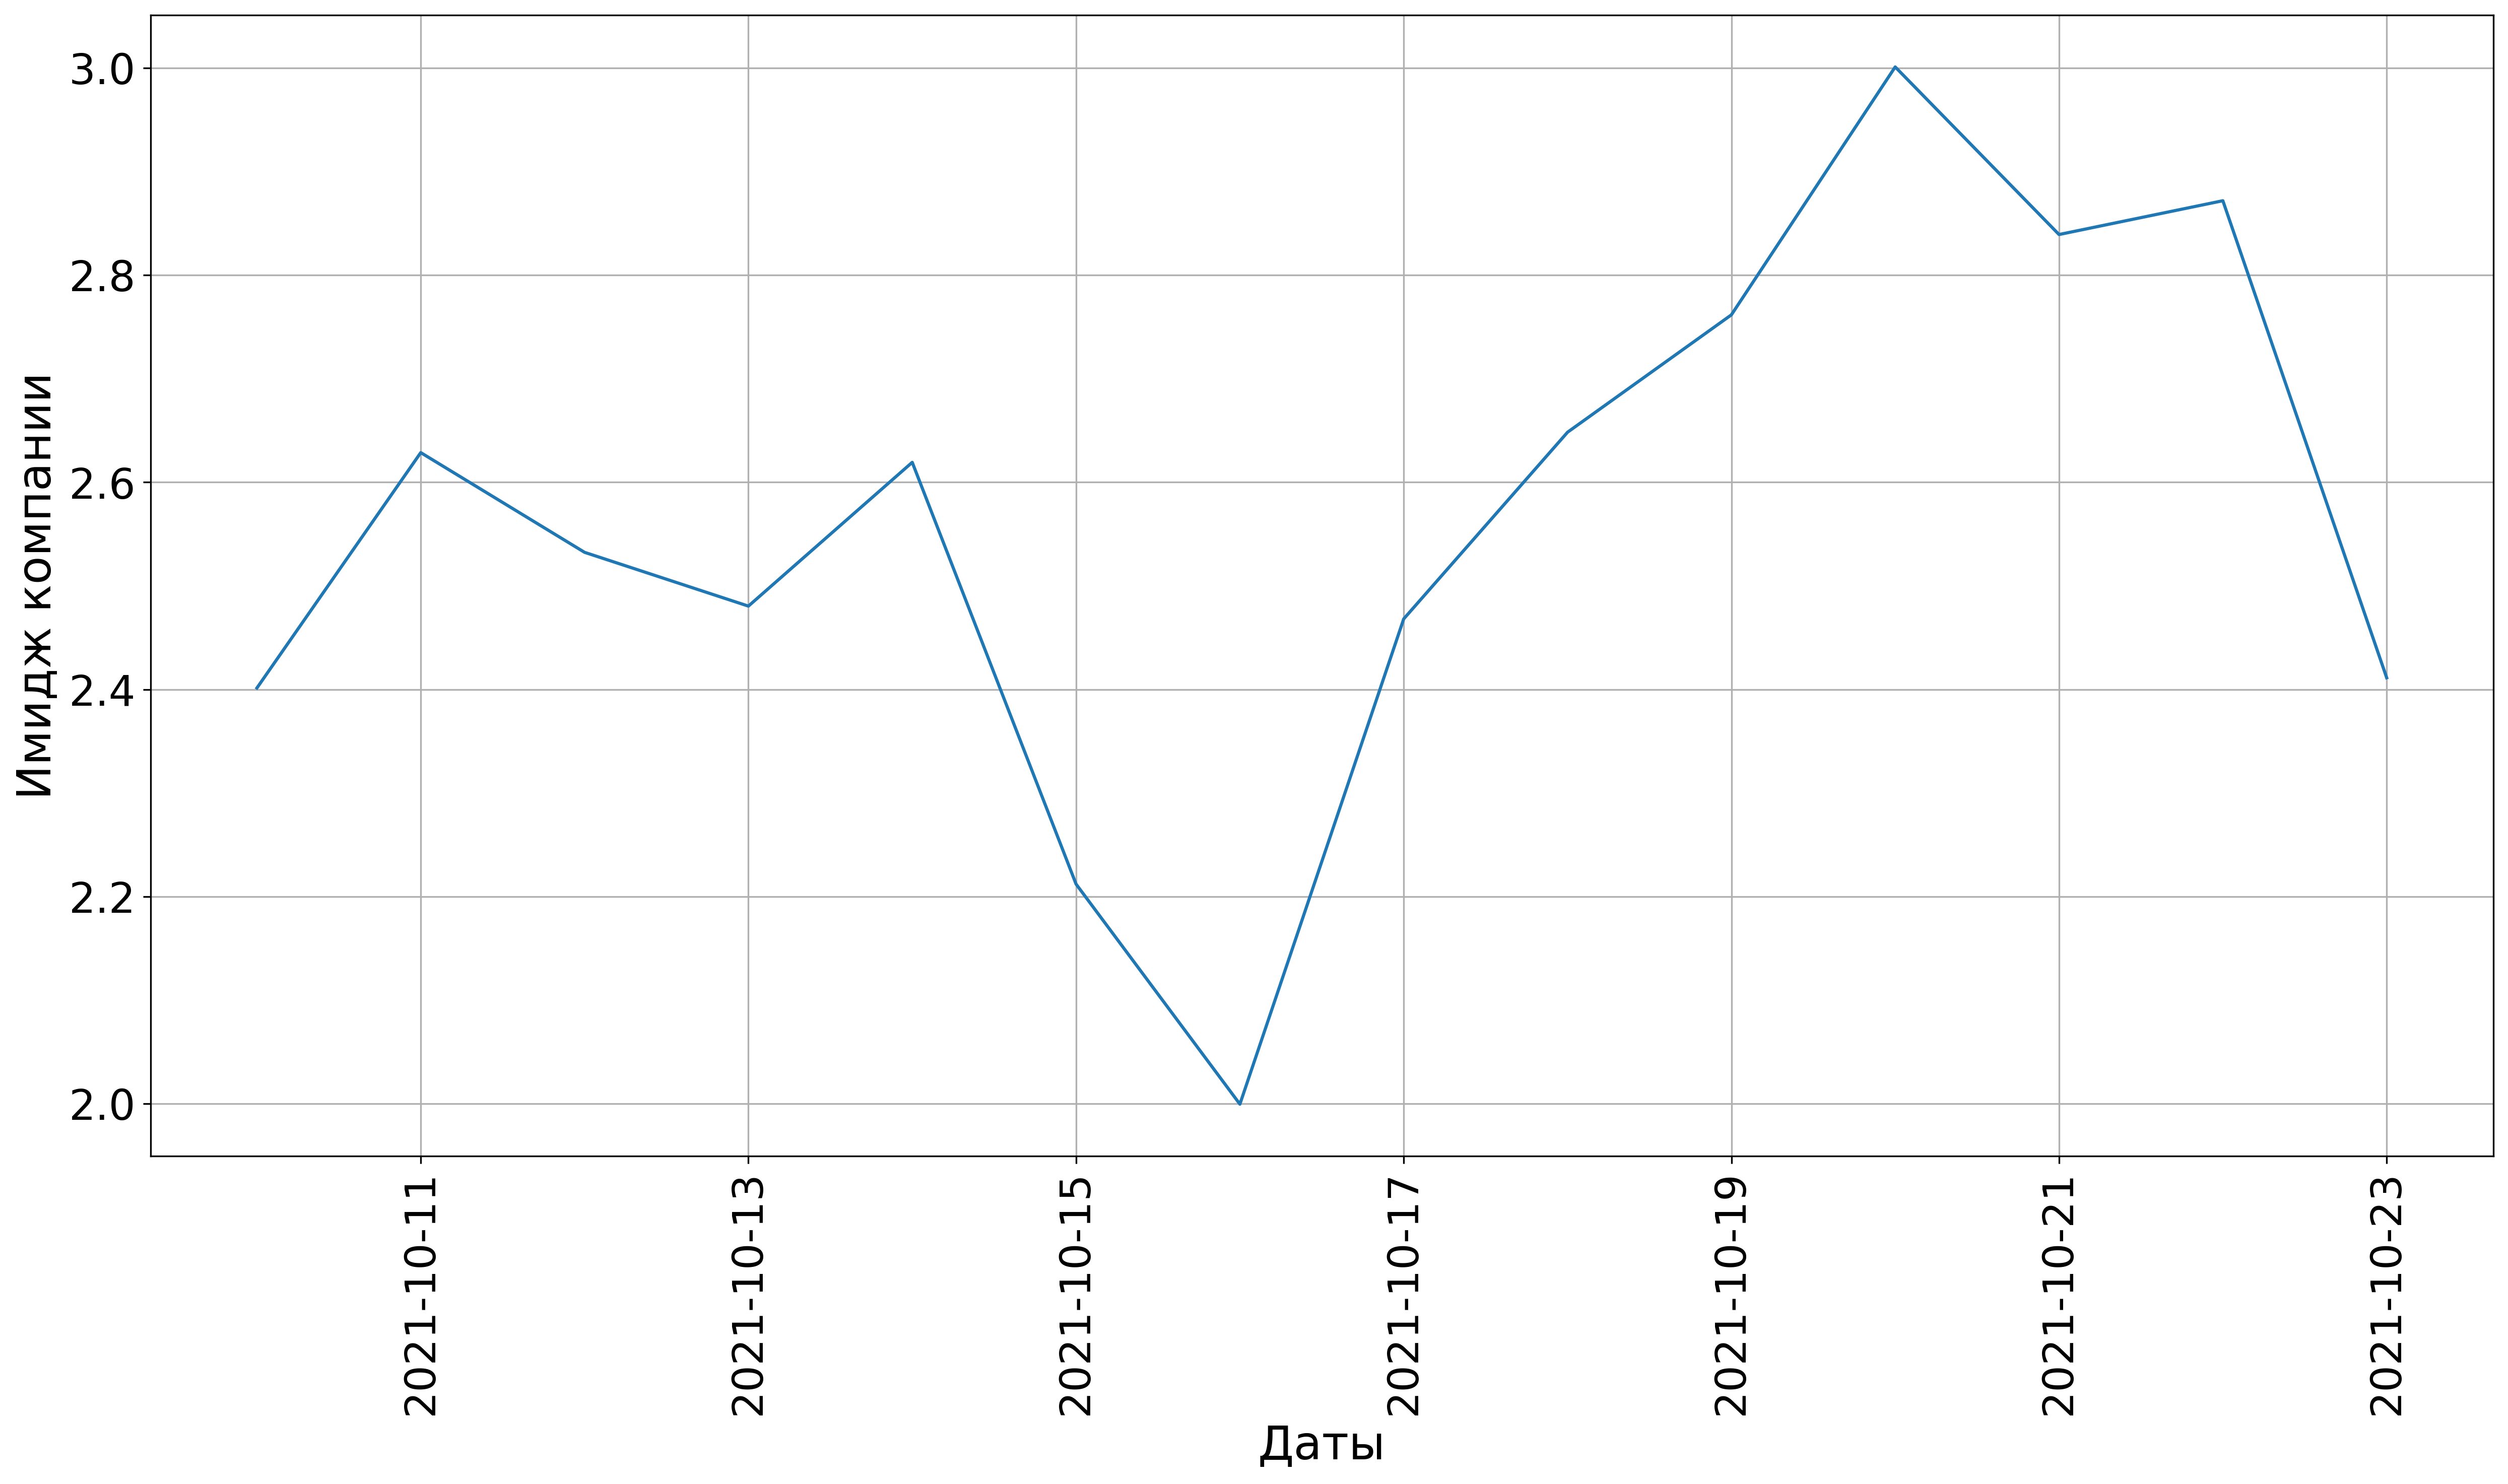

In [61]:
figure(figsize=(20,10),dpi=300)
plt.plot(df['date'],df['grade'])
plt.xlabel("Даты",fontsize=22)
plt.ylabel("Имидж компании",fontsize=22)
plt.xticks(fontsize=20,rotation=90)
plt.yticks(fontsize=20)
plt.grid()
plt.show()